In [1]:
import numpy as np
import tensorflow as tf
import scipy.io.wavfile as wv
import scipy.signal as sig
import pycochleagram.cochleagram as cgram
import matplotlib.pyplot as plt
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Program Files\Anaconda3\lib\site-packages\pycochleagram-0.1-py3.6.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


In [6]:
def get_spectrogram(filename, desired_fs=0, window_length=1024, hop_length=768):
    """
    Reads a .WAV file and returns a Short Time Fourier Transform of the file contents.
    
    Parameters:
        filename: string - path of target .WAV file.
        desired_fs: int - Sampling frequency of the output. Defaults to samploing frequency of the input file.
        window_length:  int - Number of samples in each window (i.e. the horizontal length of each magnitude spectrogram).
        hop_length: int - The number of samples between the start of each window.
    
    Returns:
        f : ndarray - Array of sample frequencies.
        t : ndarray - Array of segment times.
        Zxx : ndarray - STFT of x. By default, the last axis of Zxx corresponds to the segment times.
        mag_norm: ndarray - Magnitude of x, normalised to the range [0,1].
    """
    #Read the requested wav file
    file_fs, x = wv.read(filename)
    if desired_fs == 0:
        desired_fs = file_fs
        
    #Downsample to desired rate
    if desired_fs != file_fs:
        secs = len(x)/file_fs
        num_samples = int(secs*desired_fs)
        x = sig.resample(x, num_samples)

    #Compute STFT
    f, t, Zxx  = sig.stft(x, desired_fs, nperseg=window_length, noverlap=window_length-hop_length)
    
    #Normalise the magnitude
    mag = abs(Zxx)
    temp = mag - mag.min()
    mag_norm = temp / temp.max()
    
    return f, t, Zxx, mag_norm

In [28]:
def get_cochleagram(filename, desired_fs=500, low_lim=50, hi_lim=20000):
    """
    Reads a .WAV file and returns a cochleagram representaion of the contents
    
    Parameters:
        filename: string - path of target .WAV file.
        desired_fs: int - Sampling frequency of the output. Defaults to 500, an estimation of human 
            auditory temporal resolution.
        low_lim: Lower limit of frequency range. Filters will not be defined below this limit.
        hi_lim: Upper limit of frequency range. Filters will not be defined above this limit.
            
    Returns:
        f : ndarray - Array of sample frequencies.
        t : ndarray - Array of segment times.
        coch : ndarray - Cochleagram of x. By default, the last axis of coch corresponds to the segment times.
        coch_norm: ndarray - Cochleagram of x, normalised to the range [0,1]
    """
    #Read the requested wav file
    file_fs, x = wv.read(filename)
    
    #Downsample to desired rate
    if desired_fs != file_fs:
        secs = len(x)/file_fs
        num_samples = int(secs*desired_fs)
        x = sig.resample(x, num_samples)

    # Compute cochleagram
    coch = cgram.human_cochleagram(x, file_fs, low_lim, hi_lim, strict=False)
    t = (np.arange(num_samples)+1)/desired_fs
    f = np.linspace(low_lim,hi_lim,105) # Need to understand how to calculate the number of filters
    
    #Normalise the response
    temp = coch - coch.min()
    coch_norm = temp / temp.max()
    
    return f, t, coch, coch_norm

In [31]:
def plot_2D_audio(f, t, x, title, vmax=0.2):
    amp = 2 * np.sqrt(2)
    plt.pcolormesh(t, f, x, vmax=vmax)
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [39]:
def spectrogram_to_wav(filename, Zxx, rate=8192):
    """
    Converts a spectrogram back in to a .WAV file
    """
    # Inverse STFT
    audio = sig.istft(Zxx, rate)
    
    # Upsample audio to original rate (?)
    
    # Write audio to file
    wv.write(filename, rate, audio)


In [40]:
spectrogram_to_wav('test.wav',Zxx)

AttributeError: 'tuple' object has no attribute 'dtype'

In [25]:
def cochleagram_to_wav():
    pass

In [29]:
f, t, Zxx, mag_norm = get_spectrogram('LDC2017S24.emb.wav', desired_fs=8192)
coch_f, coch_t, coch, coch_norm = get_cochleagram('LDC2017S24.emb.wav', hi_lim=5000)

here


C:\Program Files\Anaconda3\lib\site-packages\pycochleagram-0.1-py3.6.egg\pycochleagram\cochleagram.py:131: RuntimeWarning: input arg "hi_lim" exceeds nyquist limit for max frequency; ignore with "strict=False"
  full_filter=True, strict=strict, **erb_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\pycochleagram-0.1-py3.6.egg\pycochleagram\cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


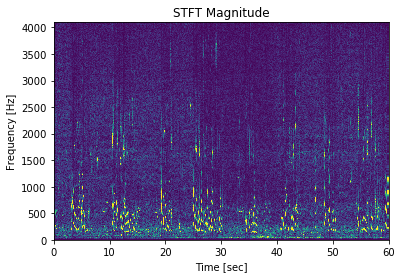

In [13]:
plot_2D_audio(f, t, mag_norm, 'STFT Magnitude')

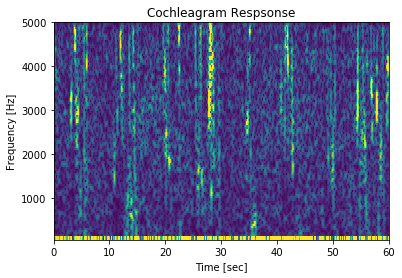

In [34]:
plot_2D_audio(coch_f, coch_t, coch_norm, 'Cochleagram Respsonse', vmax=0.2)

In [ ]:
mag_norm_tf = tf.convert_to_tensor(mag_norm, dtype=tf.float64)

In [63]:
mag_norm_tf

<tf.Tensor 'Const_1:0' shape=(513, 641) dtype=float64>

C:\Program Files\Anaconda3\lib\site-packages\pycochleagram-0.1-py3.6.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


In [67]:
file_fs, x = wv.read('LDC2017S24.emb.wav')
desired_fs = 500
secs = len(x)/file_fs
samples = int(secs*desired_fs)
x = sig.resample(x, desired_samples)

coch = cgram.human_cochleagram(x, file_fs, strict=False)
coch_t = (np.arange(samples)+1)/desired_fs
coch_f = np.linspace(50,20000,81)

here


C:\Program Files\Anaconda3\lib\site-packages\pycochleagram-0.1-py3.6.egg\pycochleagram\cochleagram.py:131: RuntimeWarning: input arg "hi_lim" exceeds nyquist limit for max frequency; ignore with "strict=False"
  full_filter=True, strict=strict, **erb_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\pycochleagram-0.1-py3.6.egg\pycochleagram\cochleagram.py:135: RuntimeWarning: divide by zero encountered in log10
  freqs_to_plot = np.log10(freqs)


In [15]:
coch

array([[698.47321333, 824.48388698, 726.09432122, ..., 412.37021938,
        414.19169423, 477.45801393],
       [684.2969012 , 820.87500203, 737.56330492, ..., 400.88352881,
        398.31226764, 461.20207463],
       [ 19.88907845,  19.8254082 ,  19.76708438, ...,  20.11072789,
         20.03188679,  19.95795345],
       ...,
       [ 50.56611882,  50.2866627 ,  50.00289628, ...,  51.37907651,
         51.11228086,  50.84130987],
       [ 23.12778353,  23.22040897,  23.31671389, ...,  22.87249133,
         22.95377588,  23.03888922],
       [  6.16704237,   6.21722109,   6.26787367, ...,   6.0195245 ,
          6.06817616,   6.11735482]])

In [35]:
wv.write('test.wav',16000,Zxx)

ValueError: Unsupported data type 'complex128'

In [37]:
audio = sig.istft(Zxx, 16000, )

numpy.ndarray